In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from fbprophet import Prophet

from datetime import datetime
from dateutil.relativedelta import relativedelta

# Check for a list of dates if any of those (relative) dates was an outlier in the past
# By relative dates, it means that, for example, friday 8th october 2021 == friday 9th october 2020

In [2]:
df = pd.read_csv('C:\\Users\\BrunoMendes\\Desktop\\bolsa\sisqualDados_short\\3 - Acesso sisqualWFM\\stores\\store_0002.csv', sep=',', index_col='ds', parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31117 entries, 2015-01-02 10:00:00 to 2020-10-18 13:30:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sales      31117 non-null  float64
 1   n_clients  31117 non-null  int64  
 2   year       31117 non-null  int64  
 3   month      31117 non-null  int64  
 4   day        31117 non-null  int64  
 5   halfhour   31117 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 1.7 MB


<AxesSubplot:xlabel='ds'>

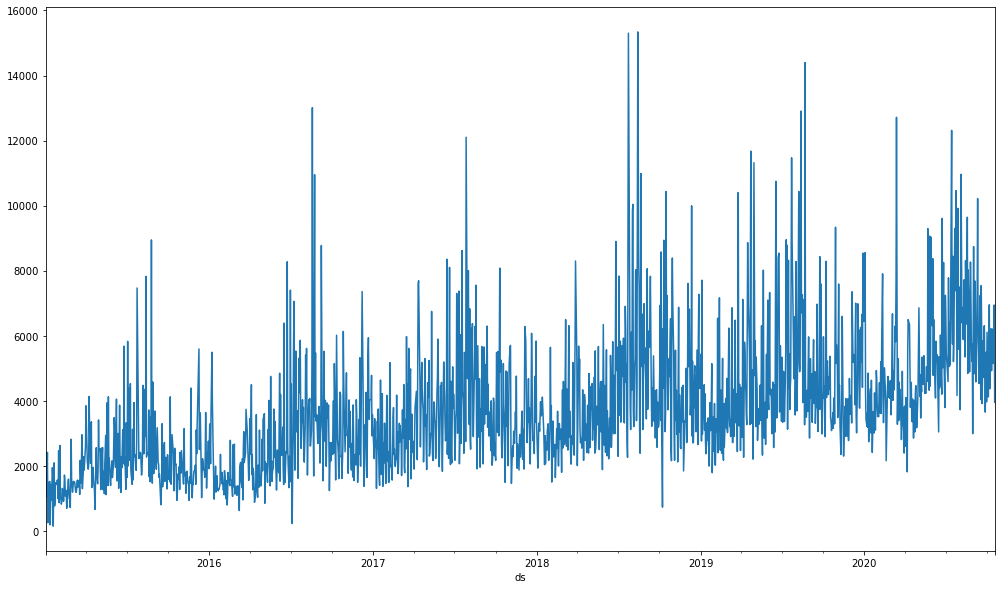

In [3]:
df_day = df[['sales','n_clients']].resample('D').sum()

# imput close days and signal them
df_day['imput'] = ~df_day['sales'].astype('bool')
df_day.loc[df_day['sales'] == 0, ['sales']] = np.nan
df_day.interpolate(method='linear', inplace=True)
df_day['sales'].plot(figsize=(17,10))

In [4]:
df_day.reset_index(inplace=True)
df_day = df_day.rename(columns={'sales':'y'})
df_day

,ds,y,n_clients,imput
0,2015-01-02,1138.340,43,False
1,2015-01-03,1047.000,34,False
2,2015-01-04,1731.105,0,True
3,2015-01-05,2415.210,69,False
4,2015-01-06,252.700,3,False
...,...,...,...,...
2112,2020-10-14,5252.580,184,False
2113,2020-10-15,5149.620,163,False
2114,2020-10-16,5266.370,206,False
2115,2020-10-17,6946.120,160,False


In [5]:
# train test split
TRAIN_LIMIT = 1856+15+30
TEST_SIZE = 30

df_train = df_day[:TRAIN_LIMIT]
df_test = df_day[TRAIN_LIMIT:TRAIN_LIMIT+TEST_SIZE]

START_DATE = df_train.iloc[0].ds

In [6]:
# mark outliers in train set
model = Prophet(interval_width = 0.99)
model = model.fit(df_train)

df_anom = model.predict(df_train)
df_anom['y'] = df_train['y'].reset_index(drop = True)

df_anom['anomaly'] = 0
df_anom.loc[df_anom['y'] > df_anom['yhat_upper'], 'anomaly'] = 1
df_anom.loc[df_anom['y'] < df_anom['yhat_lower'], 'anomaly'] = 1

df_train = df_anom[['ds','y','yhat','anomaly']]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


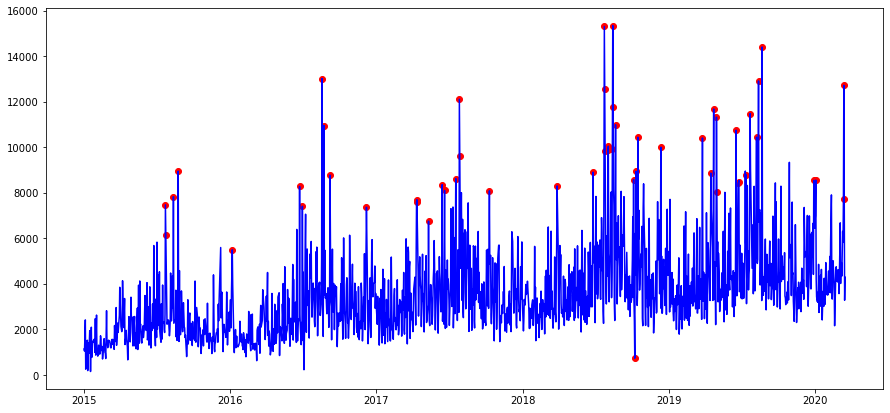

In [7]:
fig, ax = plt.subplots(figsize=(15,7))
a = df_train.loc[df_train['anomaly'] == 1, ['ds', 'y']] #anomaly

ax.plot(df_train['ds'], df_train['y'], color='blue')
ax.scatter(a['ds'],a['y'], color='red')

plt.show();

In [8]:
df_test['anomaly'] = 0

for d in df_test['ds']:
    #print(d)
    # começar no ano anterior
    relative_d = d - relativedelta(seconds=604800*52)
    count = 0
    while (relative_d > START_DATE):
        count = count + 1
        # verificar a existencia de uma anomalia passada
        # futuro.... colocar um contador de anomalias em vez de um valor binario?
        if (df_train.loc[df_train['ds'] == str(relative_d.date()), 'anomaly'].values[0] == 1):
            # sinaliza na data do d atual
            df_test.loc[df_test['ds'] == str(d.date()), 'anomaly'] = 1
        # recuar outro ano
        relative_d = relative_d - relativedelta(seconds=604800*52)
    #print(count)

<ipython-input-8-d2d0fc74b556>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['anomaly'] = 0
C:\Users\BrunoMendes\anaconda3\envs\EnvML\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [9]:
df_test[['ds','y','anomaly']]

,ds,y,anomaly
1901,2020-03-17,5301.140000,0
1902,2020-03-18,3392.380000,0
1903,2020-03-19,4568.360000,0
1904,2020-03-20,3673.330000,0
1905,2020-03-21,4346.380000,0
1906,2020-03-22,3847.840000,0
1907,2020-03-23,3349.300000,0
1908,2020-03-24,2807.920000,1
1909,2020-03-25,3197.010000,1
1910,2020-03-26,4908.500000,0
